In [1]:
################################################################
# Scirpt_Name: Mean_Areal_Value.py                             #
# Purpose(s): 1. Looping through all selected watersheds       #
#                Shp file                                      #
#             2. Looping through all GeoTIFF PET data-sets     # 
#             2. Masking all GeoTIFF PET data-sets with Shp    #
#                files, and concatenating into one inified     #
#                .NC file                                      #
#             3.Calculating the mean areal value time series   #
#               for each selected watersheds and save the file #
#               at local disk in .CSV format                   #
################################################################
# Written by Lujun Zhang @ U of Oklahoma 03/31/2020            #
# REVISION HISTORY                                             #
# 20200331 -- Initial version completed by Lujun @ OU          #
################################################################
# Requie packages: Numpy, Pandas, necCDF4, GDAL                #
################################################################

In [2]:
import numpy as np
import numpy.ma as ma
import pandas as pd
from datetime import timedelta
import sys
import os
import time
import datetime
from netCDF4 import Dataset  
from osgeo import gdal, ogr
import matplotlib.pyplot as plt
import matplotlib as mpl 
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import interp
from multiprocessing import Pool
from ftplib import FTP
import gdal

In [3]:
# Clipping NMME Members Using shapefile
def GeoTIFF_Mask(GeoInput,ShpFileDirec):
    '''
    1) This function:
    - clipping & Masking the origional GeoTIFF dataset accorindg to 
      a certain given input shapefile;
    - returns a masked Numpy Array over desired region
    2) The input elements are explainted below:
    - GeoInput: a GeoTIFF Dataset directory
    - ShpFileDirec: Shape file's directory in str format
    '''
    #########################################################################################################
    ## Before anything Remerber to make sure the long & latitude between input shapefile and PET dataset   ##
    #  are consistent with each other                                                                       #
    ##-----------------------------------------------------------------------------------------------------##
    #  Here we do not modify either GeoTiff data-sets' longitude or shpfiles' Longitude since they all have #
    #  the same range of [-180,180] which are consistent with each other already                            #
    ##-----------------------------------------------------------------------------------------------------##
    # However such shifting processes could be done using the 'ogr2ogr' package within the command line     #
    # window. The example code with the purpose of shifing 'Mill.shp' is shown below:                       #
    # ogr2ogr Mill_Shifted.shp Mill.shp -dialect sqlite -sql "SELECT ShiftCoords(geometry,360,0) FROM Mill" #
    #########################################################################################################
    ##read shapefile   
    shpDS = ogr.Open(ShpFileDirec)
    shpLyr = shpDS.GetLayer()
    Envelop = shpLyr.GetExtent() 
    xmin,xmax,ymin,ymax = [Envelop[0],Envelop[1],Envelop[2],Envelop[3]]    #Your extents as given above
   #xmin = xmin-0.04168701
   #xmax = xmax+0.04168701
   #ymin = ymin-0.041664124
   #ymax = ymax+0.041664124
    mask_RES = []
    
    ## Extract Origin GeoTIFF Data 
    gdal.GetDriverByName('GTiff').Register()
    img = gdal.Open(GeoInput)
    band = img.GetRasterBand(1)
    geoinfo = img.GetGeoTransform()
    lon_res = geoinfo[1]; originX = geoinfo[0];
    lat_res = -geoinfo[5]; originY = geoinfo[3]; 
    
    varData_Ori = band.ReadAsArray()
    varData_Ori = np.ma.array(varData_Ori)
    lon_Ori = sorted(np.arange(originX, originX+lon_res*(np.shape(varData_Ori)[1])+0.001, lon_res))
    lon_Ori = np.array(lon_Ori)
    lat_Ori = sorted(np.arange(originY-lat_res*(np.shape(varData_Ori)[0]), originY, lat_res))
    lat_Ori = np.array(lat_Ori)
    
    ##Create mask
    if len(mask_RES) == 0 :
        #get boundary and xs ys
        lat_bnds, lon_bnds = [ymin-lat_res, ymax+lat_res], [xmin-lon_res,xmax+lon_res]
        lat_inds = np.where((lat_Ori >= (lat_bnds[0])) & (lat_Ori <= lat_bnds[1]))
        lon_inds = np.where((lon_Ori >= (lon_bnds[0])) & (lon_Ori <= lon_bnds[1]))
        ncols = len(lon_inds[0])
        nrows = len(lat_inds[0])

        #nreftime = len(ref_Ori)
        #create geotransform
        xres = (xmax - xmin) / float(ncols)
        yres = (ymax - ymin) / float(nrows)
        geotransform = (xmin,xres,0,ymax,0,-yres)
        #create mask
        mask_DS = gdal.GetDriverByName('MEM').Create('', ncols, nrows, 1 ,gdal.GDT_Int32)
        mask_RB = mask_DS.GetRasterBand(1)
        mask_RB.Fill(0) #initialise raster with zeros
        mask_RB.SetNoDataValue(-32767)
        mask_DS.SetGeoTransform(geotransform)
        maskvalue = 1
        err = gdal.RasterizeLayer(mask_DS, [maskvalue], shpLyr)
        mask_DS.FlushCache()
        mask_array = mask_DS.GetRasterBand(1).ReadAsArray()    
        mask_RES = ma.masked_equal(mask_array, 255)          
        ma.set_fill_value(mask_RES, -32767)
        mask = np.expand_dims(np.logical_not(np.flipud(mask_RES.mask)),0)
    ##Set Mask
    var_subset = varData_Ori[min(lon_inds[0]):max(lon_inds[0])+1,min(lat_inds[0]):max(lat_inds[0])+1]
    #var_subset.__setmask__(mask) # update mask (flipud is reverse 180)
    var_subset = np.transpose(var_subset)
    lat_subset = lat_Ori[min(lat_inds[0]):max(lat_inds[0])+1] 
    lon_subset = lon_Ori[min(lon_inds[0]):max(lon_inds[0])]+360
    #print(np.shape(var_subset))
    #print(varData_Ori)
    #print(np.shape(lon_subset))
    #print(np.shape(lat_subset))
    
    return var_subset, lon_subset, lat_subset

In [4]:
# Shapefile information specification
#gtiff = 'C:/users/zhan0101/desktop/20200331 PET/Wimberly/ra20010201.tif'
#shp = 'C:/users/zhan0101/desktop/20200329 Selected_watersheds/Wimberly.shp'

#SHP_Names = ['Delaware_Shifted.shp','Mill_Shifted.shp','Sycamore_Shifted.shp','Wimberly_Shifted.shp']
Names = ['Delaware/','Mill/','Sycamore/','Wimberly/']
Add_1 = 'C:/users/zhan0101/Desktop/20200329 Selected_watersheds/'
Add_2 = 'C:/users/zhan0101/Desktop/20200331 PET/'
idx = pd.date_range(start='2001/02/01', end='2019/12/31', freq="d")

for i in Names[3:]:
    missing_counter = 0
    missing_dates = []
    SHPInput = Add_1+i[0:-1]+'.shp'
    print
    print(SHPInput)
    path = Add_2+i
    path_list = os.listdir(path)
    data = np.zeros(np.shape(path_list)[0])
    for j in range(np.size(path_list)):
        GeoInput = path+path_list[j]
        if j == 0:
            data_tab, Lon, Lat = GeoTIFF_Mask(GeoInput, SHPInput)
            data_tab = np.expand_dims(data_tab, 0)
            Data = data_tab
        elif j == range(np.size(path_list))[-1]:
            data_tab, Lon, Lat = GeoTIFF_Mask(GeoInput, SHPInput)
            data_tab = np.expand_dims(data_tab, 0)
            Data = np.concatenate((Data,data_tab),axis=0)  
            # Saving as NC file
            Out_Direc = 'F:/PET/'+i[0:-1]+'_PET.nc'
            ncOutput = Dataset(Out_Direc, 'w', format='NETCDF4')
            ncOutput.createDimension('Lon', np.size(Lon))
            ncOutput.createDimension('Lat', np.size(Lat))
            ncOutput.createDimension('T', np.shape(Data)[0])
            # Add lat Variable
            var_out_Y = ncOutput.createVariable('Lat','f',("Lat"))
            ncOutput.variables['Lat'][:] = Lat[:]
            # Add lon Variable
            var_out_X = ncOutput.createVariable('Lon','f',("Lon"))
            ncOutput.variables['Lon'][:] = Lon[:]
            # Add time Variable
            var_out_S = ncOutput.createVariable('T','f',("T"))
            ncOutput.variables['T'][:] = np.arange(np.shape(Data)[0])[:]
            # Add data Variable
            var_out_data = ncOutput.createVariable('Prec', 'f',("T","Lat","Lon"))
            ncOutput.variables['Prec'][:,:,:] = Data[:,:,:]
            # attr
            ncOutput.history = "Created datatime " + datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S") + " by LujunZ at OU"
            ncOutput.source  = "netCDF4 under python 3.6.5"
            ncOutput.close()  # close the new file  
            
            #if i == 'Wimberly/':
            #    mean_areal_value = Data
            #else:
            #    mean_areal_value = np.mean(Data,axis=(1,2))
            mean_areal_value = np.mean(Data,axis=(1,2))
            # Svaing mean areal value into .CSV format at local disk
            
            mean_areal_value = pd.DataFrame(data=mean_areal_value,index=idx,columns=None)
            mean_areal_value.to_csv('F:/PET/'+i[:-1]+'_PET.csv')
        else:
            #print(path_list[j][2:-4] == idx[j+missing_counter].strftime('%Y%m%d'))
            if path_list[j][2:-4] == idx[j+missing_counter].strftime('%Y%m%d'):
                data_tab, Lon, Lat = GeoTIFF_Mask(GeoInput, SHPInput)
                data_tab = np.expand_dims(data_tab, 0)
                Data = np.concatenate((Data,data_tab),axis=0)  
            else:
                missing_counter = missing_counter+1
                missing_dates.append(idx[j+missing_counter].strftime('%Y%m%d'))
                data_tab = np.zeros(np.shape(data_tab))
                Data = np.concatenate((Data,data_tab),axis=0)
                
                data_tab, Lon, Lat = GeoTIFF_Mask(GeoInput, SHPInput)
                data_tab = np.expand_dims(data_tab, 0)
                Data = np.concatenate((Data,data_tab),axis=0)
    print(missing_dates)

C:/users/zhan0101/Desktop/20200329 Selected_watersheds/Wimberly.shp
['20010416', '20010418']


C:\Users\zhan0101\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if sys.path[0] == '':
C:\Users\zhan0101\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  del sys.path[0]
C:\Users\zhan0101\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
C:\Users\zhan0101\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


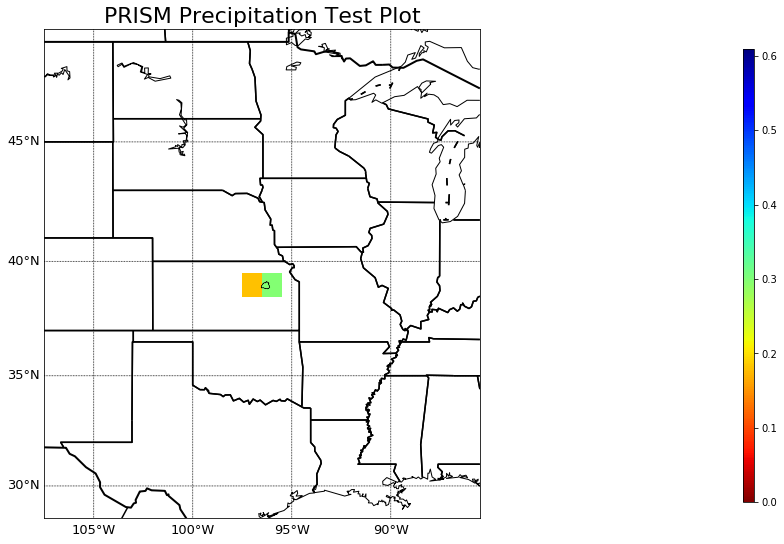

In [19]:
Data = Dataset('F:/PET/Mill_PET.nc')

Lat = Data['Lat']
Long = Data['Lon']
Prec = Data['Prec'][0,:,:]

lon_min=np.min(Long)-10; lon_max=np.max(Long)+10
lat_min=np.min(Lat)-10; lat_max=np.max(Lat)+10

plt.figure(figsize=(16,9))
plt.title('PRISM Precipitation Test Plot',fontsize=22)
m=Basemap(projection='mill',llcrnrlon=lon_min,urcrnrlon=lon_max,llcrnrlat=lat_min,urcrnrlat=lat_max,resolution='l')
shp_info = m.readshapefile("C:/users/Zhan0101/desktop/20200329 Selected_watersheds/Mill_Shifted",'MILL')

lon,lat=np.meshgrid(Long,Lat)
lon,lat=m(lon,lat)
m.drawcoastlines(linewidth=1)
m.drawstates(linewidth=1.5)
m.drawcountries(linewidth=2)
m.drawparallels(np.arange(-90, 90,5), labels=[1,0,0,0], fontsize=13,linewidth=0.8)
m.drawmeridians(np.arange(-180, 180, 5), labels=[0,0,0,1], fontsize=13,linewidth=0.8)
cmap = plt.cm.jet_r
norm = mpl.colors.Normalize(vmin=0, vmax=np.max(Prec))
#norm = mpl.colors.Normalize(vmin=0, vmax=0.01)
cf = plt.pcolormesh(lon,lat,Prec,cmap=cmap,norm=norm)
#cax = ax[1].pcolor(lon,lat,Prec[450,0,3],camp=camp)
cax=plt.axes([0.93, 0.15, 0.01,0.7])
cbar = plt.colorbar(cf,cax=cax)